Measure the Spin Qubit using RF via SHFQC device

Based upon `shfqa_qd_new_CS_20240429.ipynb` and https://github.com/zhinst/laboneq/blob/main/examples/03_superconducting_qubits/00_qubit_tuneup_shfsg_shfqa_shfqc.ipynb


In [31]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
#from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    #descriptor_shfsg_shfqa_pqsc,
#)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

Physical lines are the actual ports on the device. These are specified in the descriptor as our specific ports.

The logical lines can be any of the following. Multiple logical lines can correspond to the same physical line and their groups can be across different devices [reference](https://docs.zhinst.com/labone_q_user_manual/concepts/logical_signal_lines)
- **Drive** control lines to adjust qubits
- **Measure** line our RF measurement signal goes down
- **Acquire** response line from the measure line. Readout lines

Experiment signals are generic parameters defined for each experiment. Upon creation, they need to be mapped to logical signals. The reason for this distinction is so for superconducting qubits it is easy to change from q0 to q1 but in our case this is unnecessary


In [32]:
descriptor = """
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: set/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: p1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: p2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: j1/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: bt/drive_line  # bias tee
      ports: SGCHANNELS/4/OUTPUT
      
    - iq_signal: set/measure_line
      ports: [QACHANNELS/0/OUTPUT]
      
    - acquire_signal: set/acquire_line
      ports: [QACHANNELS/0/INPUT]
      
"""


In [33]:
def plot_sweeper(f, result, unwrap = True, deg = True):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Frequency (GHz)')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

In [34]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor, 
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# Create shortcuts to logical signals (LSG) for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}
# Use like lsg["set"]["drive_line"]

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = True

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.06.11 14:07:30.771] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/james/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/uni/quench/june/laboneq_output/log
[2024.06.11 14:07:30.773] INFO    VERSION: laboneq 2.29.0
[2024.06.11 14:07:30.775] INFO    Connecting to data server at localhost:8004
[2024.06.11 14:07:30.776] INFO    Connected to Zurich Instruments LabOne Data Server version 24.01 at localhost:8004
[2024.06.11 14:07:30.779] WARNING SHFQC/QA:dev12158: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.06.11 14:07:30.781] INFO    Configuring the device setup
[2024.06.11 14:07:30.783] INFO    The device setup is configured


In [35]:
lsg.keys()

dict_keys(['set', 'p1', 'p2', 'j1', 'bt'])

## SET Sweep

In [38]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=401)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
            ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), # add additional drive lines for P1, P2, etc
            ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
            ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep set', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.06.11 14:12:36.531] INFO    Resolved modulation type of oscillator 'osc_11' on signal 'acquire' to HARDWARE
[2024.06.11 14:12:36.532] INFO    Resolved modulation type of oscillator 'osc_9' on signal 'drive_set' to HARDWARE
[2024.06.11 14:12:36.534] INFO    Starting LabOne Q Compiler run...
[2024.06.11 14:12:36.655] INFO    Schedule completed. [0.119 s]
[2024.06.11 14:12:43.269] INFO    Code generation completed for all AWGs. [6.612 s]
[2024.06.11 14:12:43.270] INFO    Completed compilation step 1 of 1. [6.734 s]
[2024.06.11 14:12:43.277] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.11 14:12:43.278] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.11 14:12:43.278] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.11 14:12:43.279] INFO      device_shfqc        0         16            0           0         0  
[2024.06.11 14:12:43.280] INFO      device_shfqc_sg 

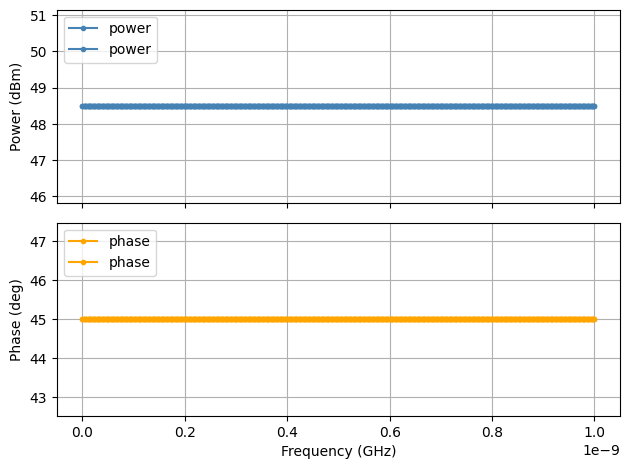

In [39]:
plot_sweeper(amp_sweep_g1, data)

## P1 sweep

In [42]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=11)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
                exp.play(signal="drive_p1", pulse=g2_pulse, amplitude = amp_sweep_g1, phase = 180)
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
                
    # Where do we add feedback? There are no "loops" for us to add it in currently...
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_bt"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.06.11 14:23:58.653] INFO    Resolved modulation type of oscillator 'osc_27' on signal 'acquire' to HARDWARE
[2024.06.11 14:23:58.655] INFO    Resolved modulation type of oscillator 'osc_23' on signal 'drive_bt' to HARDWARE
[2024.06.11 14:23:58.658] INFO    Resolved modulation type of oscillator 'osc_25' on signal 'drive_p1' to HARDWARE
[2024.06.11 14:23:58.660] INFO    Resolved modulation type of oscillator 'osc_21' on signal 'drive_set' to HARDWARE
[2024.06.11 14:23:58.665] INFO    Starting LabOne Q Compiler run...
[2024.06.11 14:23:58.675] INFO    Schedule completed. [0.005 s]
[2024.06.11 14:23:59.047] INFO    Code generation completed for all AWGs. [0.370 s]
[2024.06.11 14:23:59.052] INFO    Completed compilation step 1 of 1. [0.382 s]
[2024.06.11 14:23:59.132] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.11 14:23:59.134] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.11 14:23:59.135] INFO   

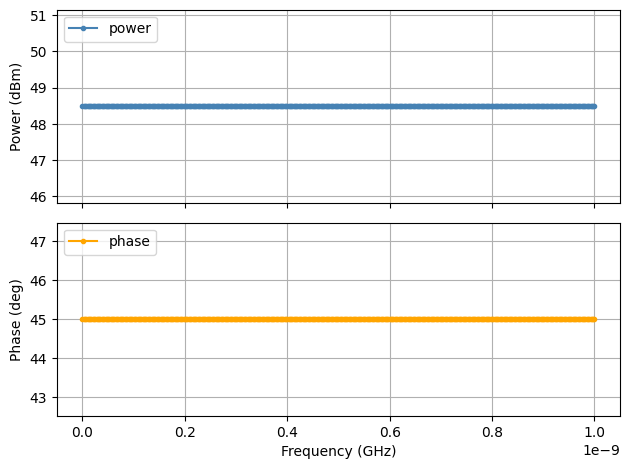

In [41]:
plot_sweeper(amp_sweep_g1, data)
